<a href="https://colab.research.google.com/github/chuancao26/islp/blob/main/nonLinearExercices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=19c734c2cec11976f4f1468978f4a3c4da30c729593e31219f810f791ee817b8
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [2]:
# algunos imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         poly,
                         summarize)
from ISLP.pygam import (plot as plot_gam,
                        anova as anova_gam,
                        approx_lam,
                        degrees_of_freedom)

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,KBinsDiscretizer

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)


# Applied

## 1

In [ ]:
wage = load_data("Wage")
age = wage["age"]

In [ ]:
wage.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [ ]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB


### a

vamos a hacer la regresion polinomial usando age para explicacar Wage
Necesitamos algunas cosas.
- especificar el kfold
- matriz de features
- algoritmo de regresion

#### Regresion Polinomial

In [ ]:
design = MS([poly("age", degree=8)]).fit(wage)

X = design.transform(wage)
y = wage["wage"]

model = sm.OLS(y, X).fit()
summarize(model)


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.308,0.000
"poly(age, degree=8)[0]",447.0679,39.908,11.202,0.000
"poly(age, degree=8)[1]",-478.3158,39.908,-11.985,0.000
"poly(age, degree=8)[2]",125.5217,39.908,3.145,0.002
"poly(age, degree=8)[3]",-77.9112,39.908,-1.952,0.051
"poly(age, degree=8)[4]",-35.8129,39.908,-0.897,0.370
"poly(age, degree=8)[5]",62.7077,39.908,1.571,0.116
"poly(age, degree=8)[6]",50.5498,39.908,1.267,0.205
"poly(age, degree=8)[7]",-11.2547,39.908,-0.282,0.778


vamos a graficar la funcion estimada

Text(0, 0.5, 'wage')

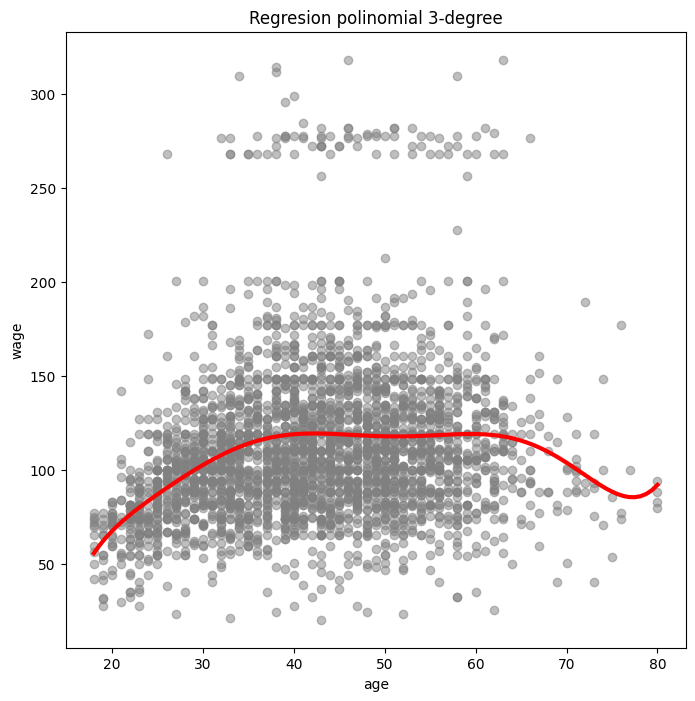

In [ ]:
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
predicted = model.predict(design.transform(pd.DataFrame({"age": age_grid})))
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y,
           alpha=.5,
           facecolor="gray");
# Grafico de la funcion de regresion
ax.plot(age_grid, predicted,
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 3-degree")
ax.set_xlabel("age")
ax.set_ylabel("wage")


Vamos a validar los resultados con cross validation con k = 10

In [ ]:
k = 10
kfold = skm.KFold(k,
              shuffle=True,
              random_state=2)
results = skm.cross_val_score(skl.LinearRegression(),
                              X,
                              y,
                              scoring="neg_mean_squared_error",
                              cv=kfold)
print(f"Simple Polinomial regression 3-d con un score de: {np.mean(-results)}")

Simple Polinomial regression 3-d con un score de: 1596.5930103094584


#### Wise Selection of d

Ahora vamos a buscar el mejor modelo con diferentes valores para d:


In [ ]:
degrees = np.arange(1, 10 + 1)
mse = np.zeros(10)
kfold = skm.KFold(5,
              shuffle=True,
              random_state=2)
for d in degrees:

  design = MS([poly("age", degree=d)])

  pipe = Pipeline([("design", design),
                  ("model", skl.LinearRegression())])

  results = skm.cross_validate(pipe,
                              wage,
                              wage["wage"],
                              scoring="neg_mean_squared_error",
                               cv=kfold)

  mse[d-1] = np.mean(-results["test_score"])

In [ ]:
mse

array([1675.07800104, 1599.71568141, 1594.7607508 , 1593.39352217,
       1593.42232694, 1592.99793417, 1592.94603594, 1593.69403581,
       1592.67457781, 1594.21194103])

Text(0, 0.5, 'MSE')

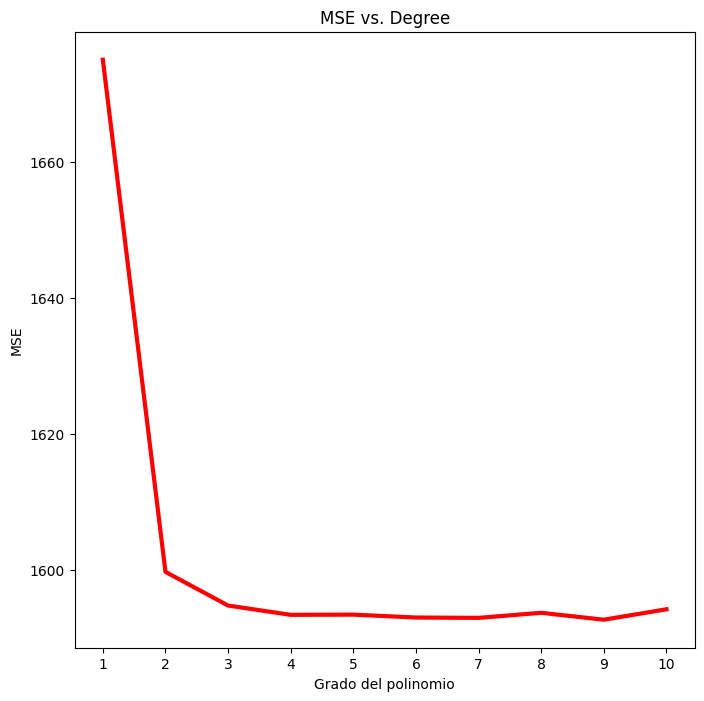

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(degrees, mse,
        linewidth=3,
        color="red")
ax.set_xticks(degrees)
ax.set_title("MSE vs. Degree")
ax.set_xlabel("Grado del polinomio")
ax.set_ylabel("MSE")

Podemos apreciar una caida mas que evidente con un modelo con 3 a 4 grados en el polinomio


In [ ]:
# graficamos el modelo con 4-degree
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
design = MS([poly("age", degree=4)])

pipe = Pipeline([("design", design),
                ("model", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             wage,
                             wage["wage"],
                             scoring="neg_mean_squared_error",
                             cv=kfold)
print(f"Simple Polinomial regression 4-d con un score de: {np.mean(-results['test_score'])}")

Simple Polinomial regression 4-d con un score de: 1595.0572027232408


Veamos el analisis ANOVA con modelos polinomiales con d tomando valores de 1 a 6

In [ ]:
models = []
for d in range(1, 6 + 1):
  design = MS([poly("age", degree=d)])
  X = design.fit_transform(wage)

  model = sm.OLS(wage["wage"], X).fit()
  models.append(model)

In [ ]:
print(anova_lm(*models))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.663571  2.285169e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.893609  1.674794e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.811683  5.098933e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805371  3.695646e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.469216  1.162015e-01


Con estos resultados, podemos decir que el valor p es significativo hasta un modelo  con d = 4 sin embargo el modelo con d=3 es mejor ya que el cambio no es tan significativo.

##### GridSearch

In [ ]:
age = wage["age"]
y = wage["wage"]

k=5
kfold = skm.KFold(k,
                  shuffle=True,
                  random_state=1)
params_grid = {"poly__degree": np.arange(1, 20)}

pipe = Pipeline([("poly", PolynomialFeatures()),
                 ("model", skl.LinearRegression())])

cv_grid = skm.GridSearchCV(pipe,
                           param_grid=params_grid,
                           cv=kfold,
                           scoring="neg_mean_squared_error").fit(np.reshape(age, (-1,1)),
                                         y)
cv_grid


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             param_grid={'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='neg_mean_squared_error')

In [ ]:
best_degree = cv_grid.best_params_["poly__degree"]
best_degree


np.int64(8)

In [ ]:
pipe = Pipeline([("poly", PolynomialFeatures(degree=8)),
                  ("linreg", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             np.reshape(wage["age"], (-1,1)),
                             wage["wage"],
                             scoring="neg_mean_squared_error",
                             cv=kfold)
np.mean(-results["test_score"])
#

np.float64(1592.1024401205923)

In [ ]:
pipe.fit(np.reshape(wage["age"], (-1,1)), wage["wage"])

Pipeline(steps=[('poly', PolynomialFeatures(degree=8)),
                ('linreg', LinearRegression())])

In [ ]:
# hagamos el analisis ANOVA
designs = [MS([poly("age", degree=i)]) for i in range(1, best_degree + 1)]
models = [sm.OLS(wage["wage"], design.fit_transform(wage)).fit() for design in designs]
print(anova_lm(*models))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.648400  2.301885e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.892564  1.675742e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.811280  5.100157e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805286  3.695898e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.468956  1.162208e-01
6    2992.0  4.763834e+06      1.0    2555.281281    1.604390  2.053807e-01
7    2991.0  4.763707e+06      1.0     126.668985    0.079532  7.779522e-01


Text(0.5, 1.0, 'Regresion polinomial 8-degree')

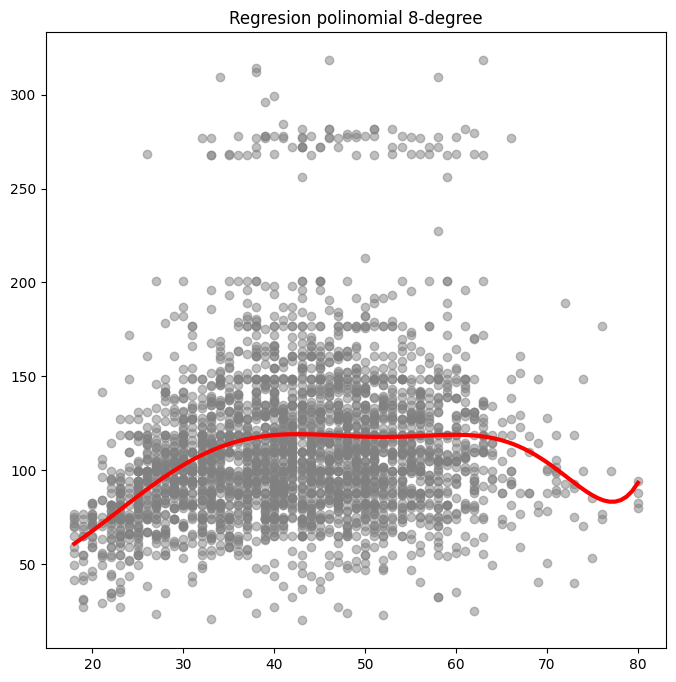

In [ ]:
# Vamos a graficar el modelo mas optimo (d = 8)
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y, facecolor="gray", alpha=.5)
# Graficando la funcion estimada
ax.plot(age_grid, pipe.predict(np.reshape(age_grid, (-1 ,1))),
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 8-degree")

#### b con el uso de dizcreticer

In [ ]:
param_grid = {"discretizer__n_bins": np.arange(2, 21)}

kfold = skm.KFold(5,
              shuffle=True,
              random_state=2)
pipe = Pipeline([("discretizer", KBinsDiscretizer(encode="onehot-dense", strategy="uniform")),
                 ("linreg", skl.LinearRegression())])

results = skm.GridSearchCV(pipe,
                           scoring="neg_mean_squared_error",
                           param_grid=param_grid,
                           cv=kfold).fit(np.reshape(wage["age"], (-1,1)),
                                         wage["wage"])
results

GridSearchCV(cv=KFold(n_splits=5, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('discretizer',
                                        KBinsDiscretizer(encode='onehot-dense',
                                                         strategy='uniform')),
                                       ('linreg', LinearRegression())]),
             param_grid={'discretizer__n_bins': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])},
             scoring='neg_mean_squared_error')

In [ ]:
-results.cv_results_["mean_test_score"]

array([1730.10349892, 1681.41022675, 1634.12680118, 1630.71704254,
       1622.59011854, 1611.11633064, 1599.16221174, 1609.57471004,
       1606.43266379, 1602.15159771, 1605.54784822, 1606.91919078,
       1609.85106245, 1607.08067067, 1604.49426491, 1609.98795319,
       1608.94504453, 1610.29422049, 1610.9139206 ])

Text(0.5, 1.0, 'Regresion polinomial 8-degree')

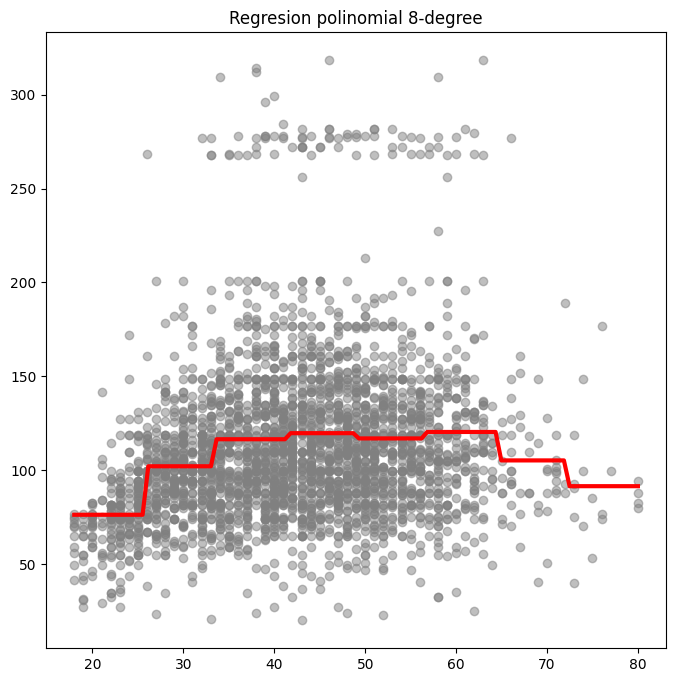

In [ ]:
# Vamos a graficar el modelo mas optimo (d = 8)
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y, facecolor="gray", alpha=.5)
# Graficando la funcion estimada
ax.plot(age_grid, best_estimator.predict(np.reshape(age_grid, (-1 ,1))),
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 8-degree")

Podemos apreciar que el mejhor modelo es un de 8-degree

### b

In [ ]:
# ahora vamos a buscar los cortes para un step function
scores = []
cuts = np.arange(1, 20)
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
for c in cuts:
  wage["cut"] = pd.cut(wage["age"], c)
  design = MS(["cut"])
  X = design.fit_transform(wage)

  results = skm.cross_validate(skl.LinearRegression(),
                               X,
                               wage["wage"],
                               scoring="neg_mean_squared_error",
                               cv=kfold)

  scores.append(np.mean(-results["test_score"]))

Text(0, 0.5, 'MSE')

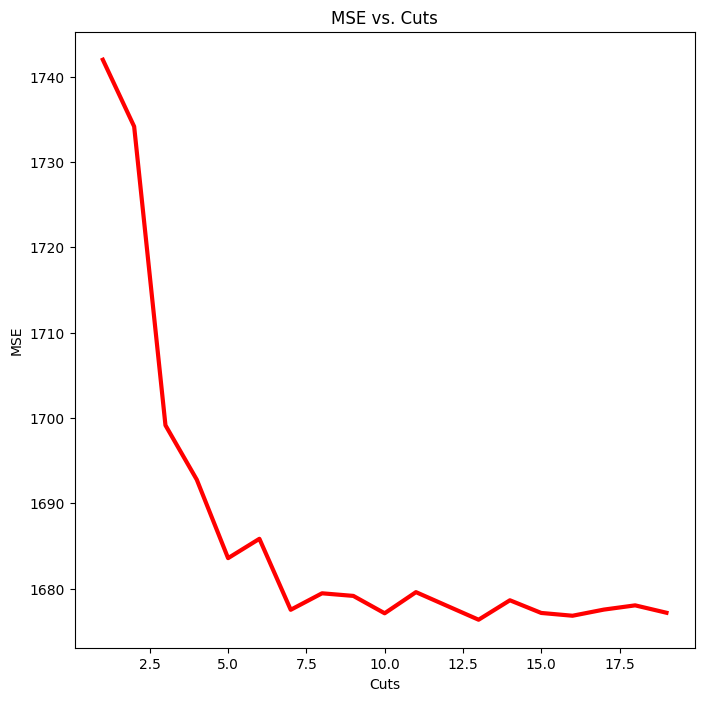

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(cuts, scores,
        linewidth=3,
        color="red")
ax.set_title("MSE vs. Cuts")
ax.set_xlabel("Cuts")
ax.set_ylabel("MSE")


El número óptimo de cortes es: 13
MSE mínimo: 1676.3553


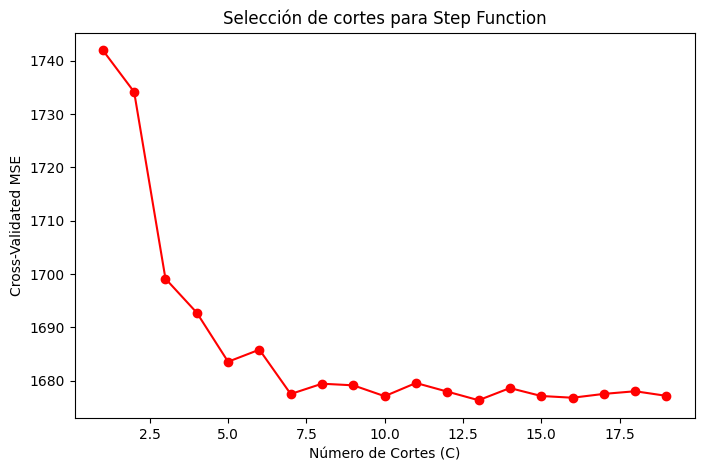

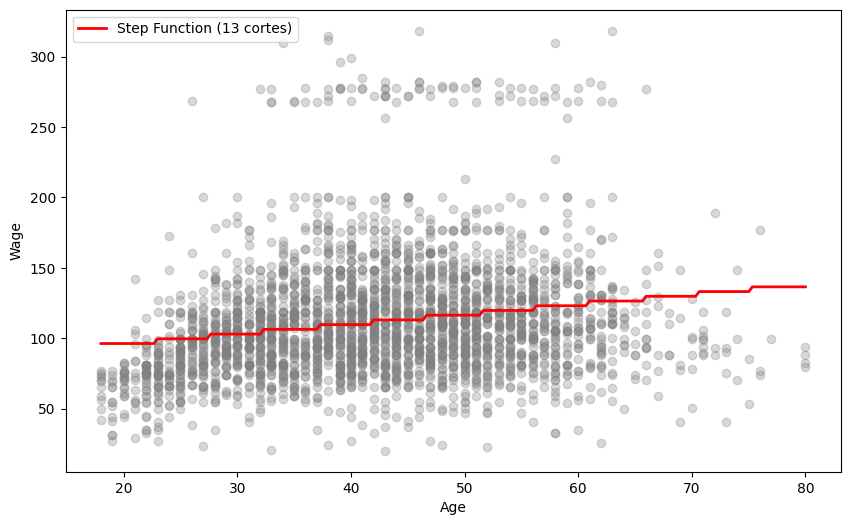

In [ ]:
import matplotlib.pyplot as plt

# 1. Encontrar el mejor 'C' (número de cortes)
best_c_idx = np.argmin(scores)
best_c = cuts[best_c_idx]
print(f"El número óptimo de cortes es: {best_c}")
print(f"MSE mínimo: {scores[best_c_idx]:.4f}")

# Graficar el error para ver el "codo"
plt.figure(figsize=(8, 5))
plt.plot(cuts, scores, marker='o', color='red')
plt.xlabel("Número de Cortes (C)")
plt.ylabel("Cross-Validated MSE")
plt.title("Selección de cortes para Step Function")
plt.show()

# ---------------------------------------------------------
# 2. Graficar el ajuste final (Fit) con el 'best_c'
# ---------------------------------------------------------

# A. Re-entrenar el modelo con TODOS los datos y el mejor corte
wage["cut"] = pd.cut(wage["age"], best_c)
design = MS(["cut"])
X_full = design.fit_transform(wage)
final_model = skl.LinearRegression().fit(X_full, wage["wage"])

# B. Crear datos ficticios para dibujar la línea escalonada
# Usamos linspace para tener muchos puntos y que se vean los escalones
age_grid = np.linspace(wage["age"].min(), wage["age"].max(), 200)
df_grid = pd.DataFrame({"age": age_grid})

# IMPORTANTE: Usar los mismos cortes (bins) que los datos originales
# Para que coincida exacto, le pasamos los mismos bordes o dejamos que pandas lo infiera igual
# Lo más seguro es usar 'retbins=True' en el original, pero aquí pd.cut suele ser consistente
df_grid["cut"] = pd.cut(df_grid["age"], bins=best_c)

# Transformar y Predecir
# Nota: Puede que necesites manejar bordes si linspace se sale por decimales,
# pero pd.cut suele aguantarlo bien.
X_grid = design.transform(df_grid)
preds = final_model.predict(X_grid)

# C. Plot Final
fig, ax = plt.subplots(figsize=(10, 6))
# Puntos reales (gris)
ax.scatter(wage["age"], wage["wage"], facecolor="gray", alpha=0.3)
# Línea de predicción (roja)
ax.plot(age_grid, preds, color="red", linewidth=2, label=f"Step Function ({best_c} cortes)")

ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.legend()
plt.show()

## 7

In [ ]:
# vamos a tomar en cuenta algunos features ignorados hasta ahora/
wage = load_data("Wage")
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [ ]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB


In [ ]:
wage.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [ ]:
wage.describe(include="category")

,maritl,race,education,region,jobclass,health,health_ins
count,3000,3000,3000,3000,3000,3000,3000
unique,5,4,5,1,2,2,2
top,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes
freq,2074,2480,971,3000,1544,2142,2083


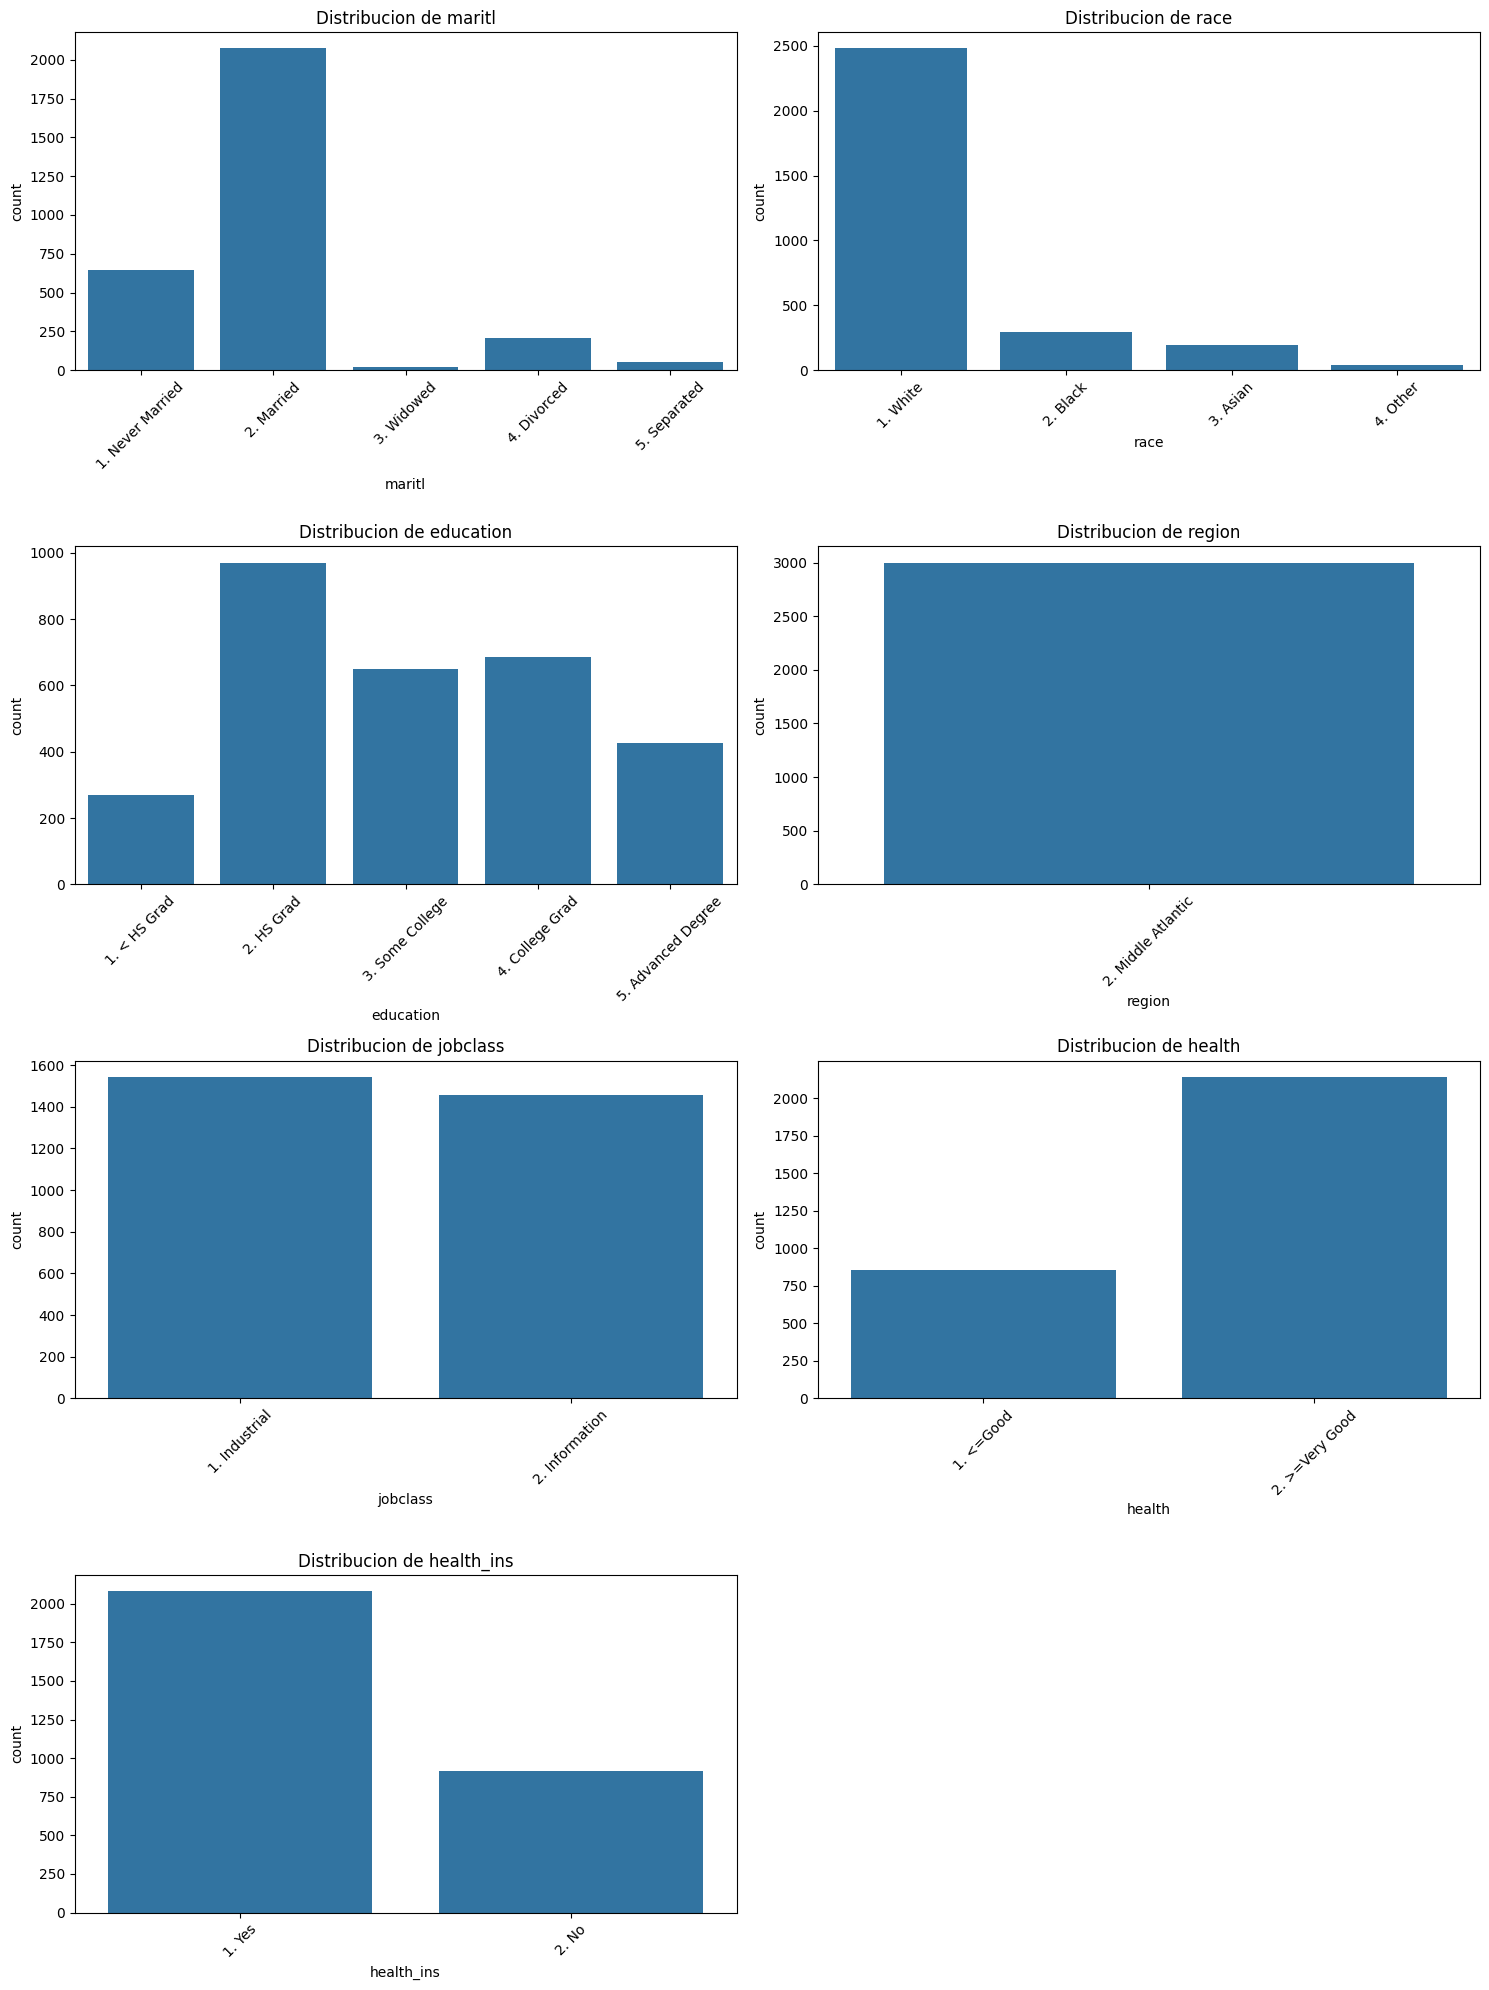

In [ ]:
cat_cols = wage.select_dtypes(include="category").columns

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15,20))

ax = ax.flatten()

for i, col in enumerate(cat_cols):
  sns.countplot(data=wage, x=col, ax=ax[i])
  ax[i].tick_params(axis="x", rotation=45)
  ax[i].set_title(f"Distribucion de {col}")
for i in range(len(cat_cols), len(ax)):
  fig.delaxes(ax[i])
plt.tight_layout()
plt.show()

In [ ]:
# ahora vamos a ahcer un modelo GAM smoothing splines
# Vamos a tomar en cuenta y: wage X: jobclass, age, education
# matriz de features

gam_full = LinearGAM(s_gam(0)+ f_gam(1, lam=0) + f_gam(2, lam=0))

Xgam = np.column_stack([
                        wage["age"],
                        wage["jobclass"].cat.codes,
                         wage.education.cat.codes])
y = wage.wage
gam_full.fit(Xgam,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + f(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [ ]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
gam_full.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + f(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

Text(0.5, 1.0, 'Partial dependence of education on wage - lam=0')

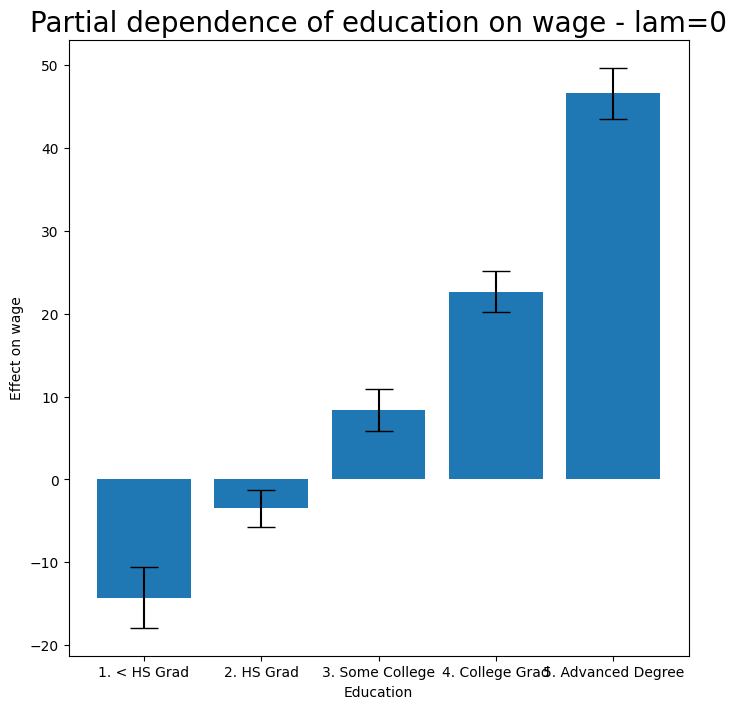

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,2, ax=ax)
ax.set_xticklabels(wage.education.cat.categories)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of education on wage - lam=0',
fontsize=20)

Text(0.5, 1.0, 'Partial dependence of jobClas on wage - lam=0')

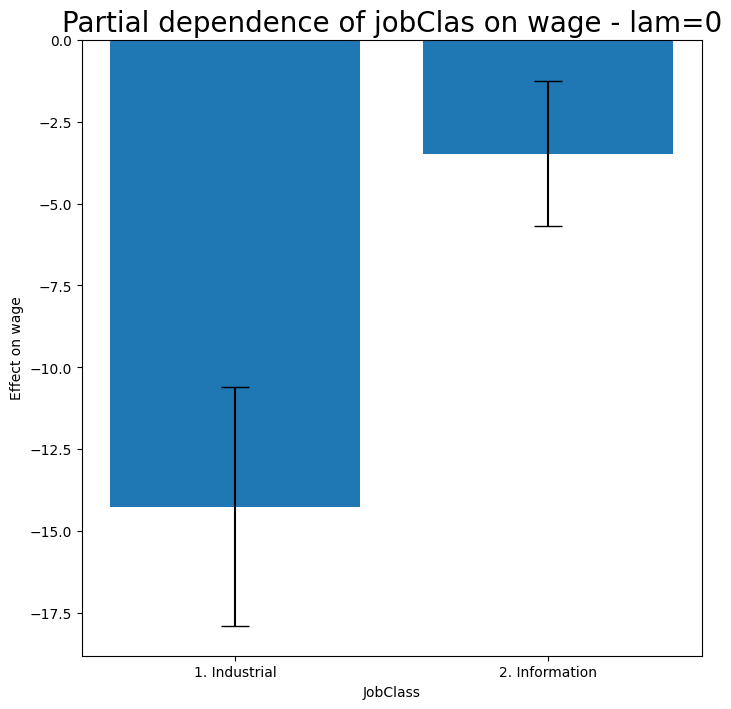

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,1, ax=ax)
ax.set_xticklabels(wage.jobclass.cat.categories)
ax.set_xlabel('JobClass')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of jobClas on wage - lam=0',
fontsize=20)

Text(0.5, 1.0, 'Partial dependence of age on wage - lam=0')

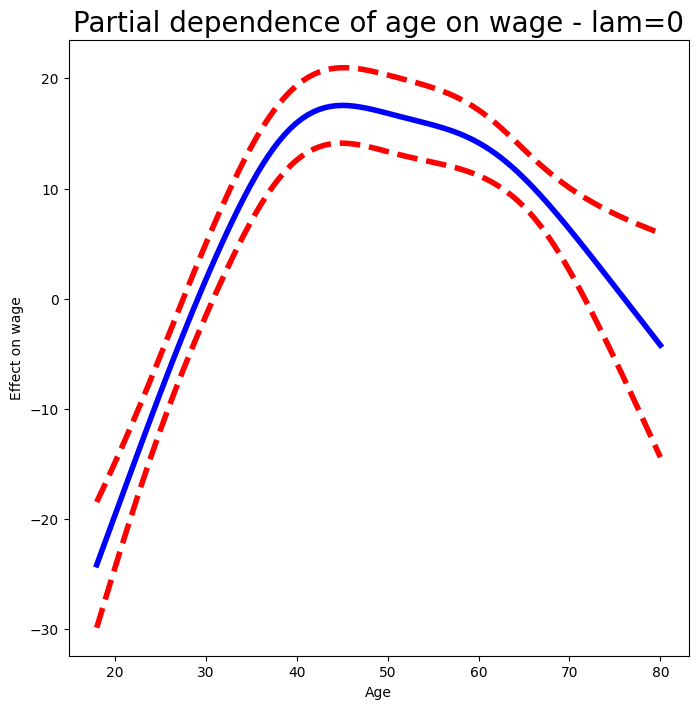

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - lam=0',
fontsize=20)

In [ ]:
def fit_gam(cols, df):
  cat_cols = df.select_dtypes(include=["category", "object"]).columns
  gam_terms = [f_gam(i, lam=0) if col in cat_cols else s_gam(i) for i, col in enumerate(cols)]
  Xgam = np.column_stack([df[col].cat.codes if col in cat_cols else df[col] for col in cols] )
  y = df["wage"]
  gam = LinearGAM(np.sum(gam_terms))
  return gam.fit(Xgam, y)

def plot_gam_terms(gam, columns: list, df:pd.DataFrame, y_name:str):
  """
  A simple function that plots partial gam plots on one figure
  """
  cat_cols = df.select_dtypes(include=['object', 'category']).columns

  n_plots = len(columns)
  n_rows = math.ceil(n_plots/3)
  n_cols = math.ceil(n_plots/n_rows)

  _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
  axes = axes.flatten()

  for i, col in enumerate(columns):
      ax = axes[i]

      plot_gam(gam, i, ax=ax)

      ax.set_xlabel(col)
      ax.set_ylabel(f'Effect on {y_name}')
      ax.set_title(f'Partial dependence of {col} on {y_name}')

      if col in cat_cols:
          ax.set_xticklabels(df[col].cat.categories)
          ax.tick_params(axis='x', labelrotation=23)

  plt.tight_layout()

In [ ]:
def fit_gam(columns: list, df: pd.DataFrame) -> LinearGAM:
    """
    A simple function that fits gam models using factor terms with lam=0 for categorical variables
    and spline terms with default lam=0.6 for numerical variables.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    gam_terms = [f_gam(i, lam=0) if col in cat_cols else s_gam(i) for i, col in enumerate(columns)]
    X_terms = [df[col].cat.codes if col in cat_cols else df[col] for col in columns]

    gam = LinearGAM(np.sum(gam_terms))
    Xgam = np.column_stack(X_terms)
    return gam.fit(Xgam, y)


def plot_gam_terms(gam, columns: list, df:pd.DataFrame, y_name:str):
    """
    A simple function that plots partial gam plots on one figure
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    n_plots = len(columns)
    n_rows = math.ceil(n_plots/3)
    n_cols = math.ceil(n_plots/n_rows)

    _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]

        plot_gam(gam, i, ax=ax)

        ax.set_xlabel(col)
        ax.set_ylabel(f'Effect on {y_name}')
        ax.set_title(f'Partial dependence of {col} on {y_name}')

        if col in cat_cols:
            ax.set_xticklabels(df[col].cat.categories)
            ax.tick_params(axis='x', labelrotation=23)

    plt.tight_layout()

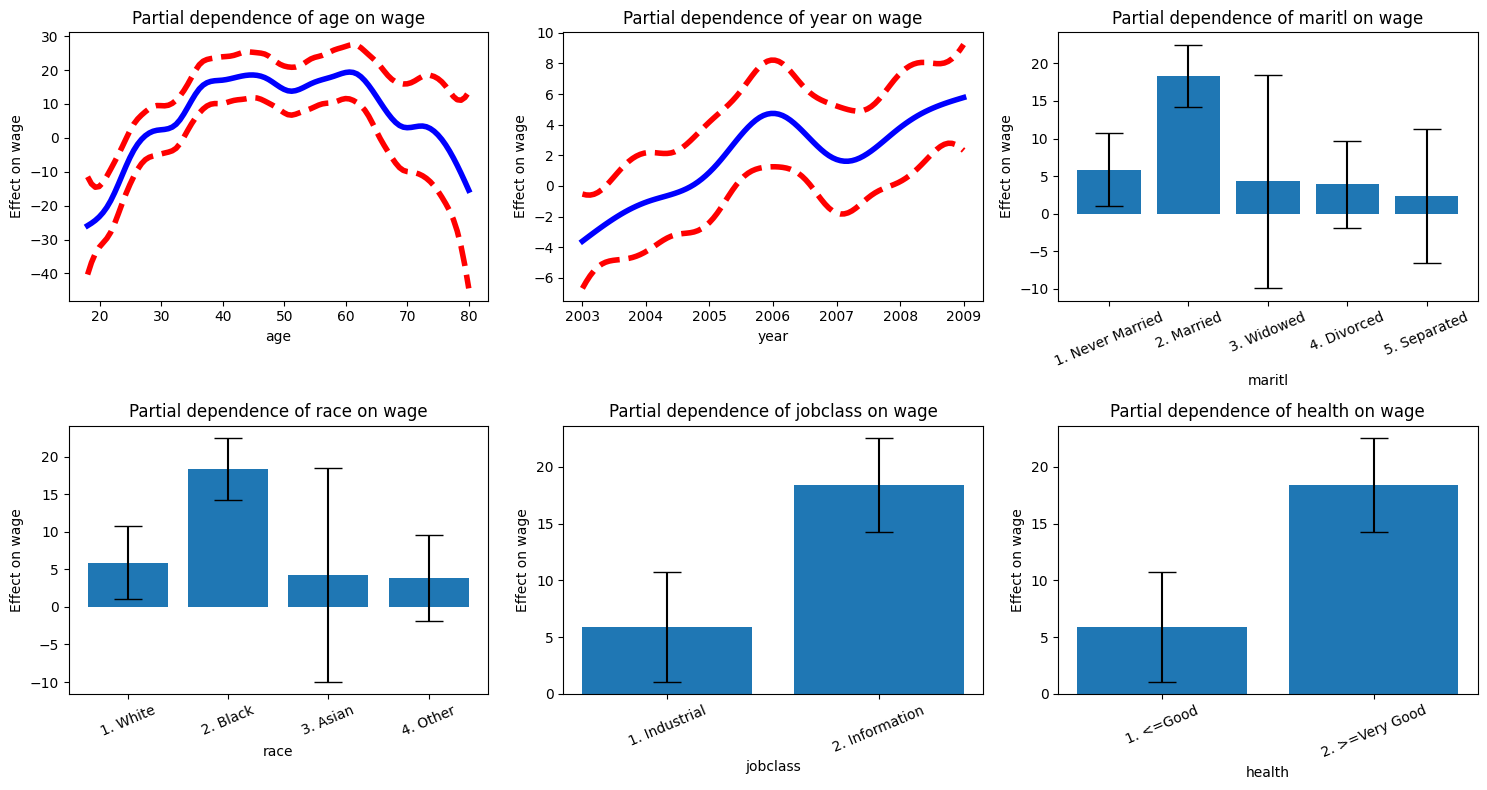

In [ ]:
cols = ['age', 'year', 'maritl', "race", "jobclass", "health"]
gam_maritl = fit_gam(cols, wage)
plot_gam_terms(gam_maritl, cols, wage, 'wage')

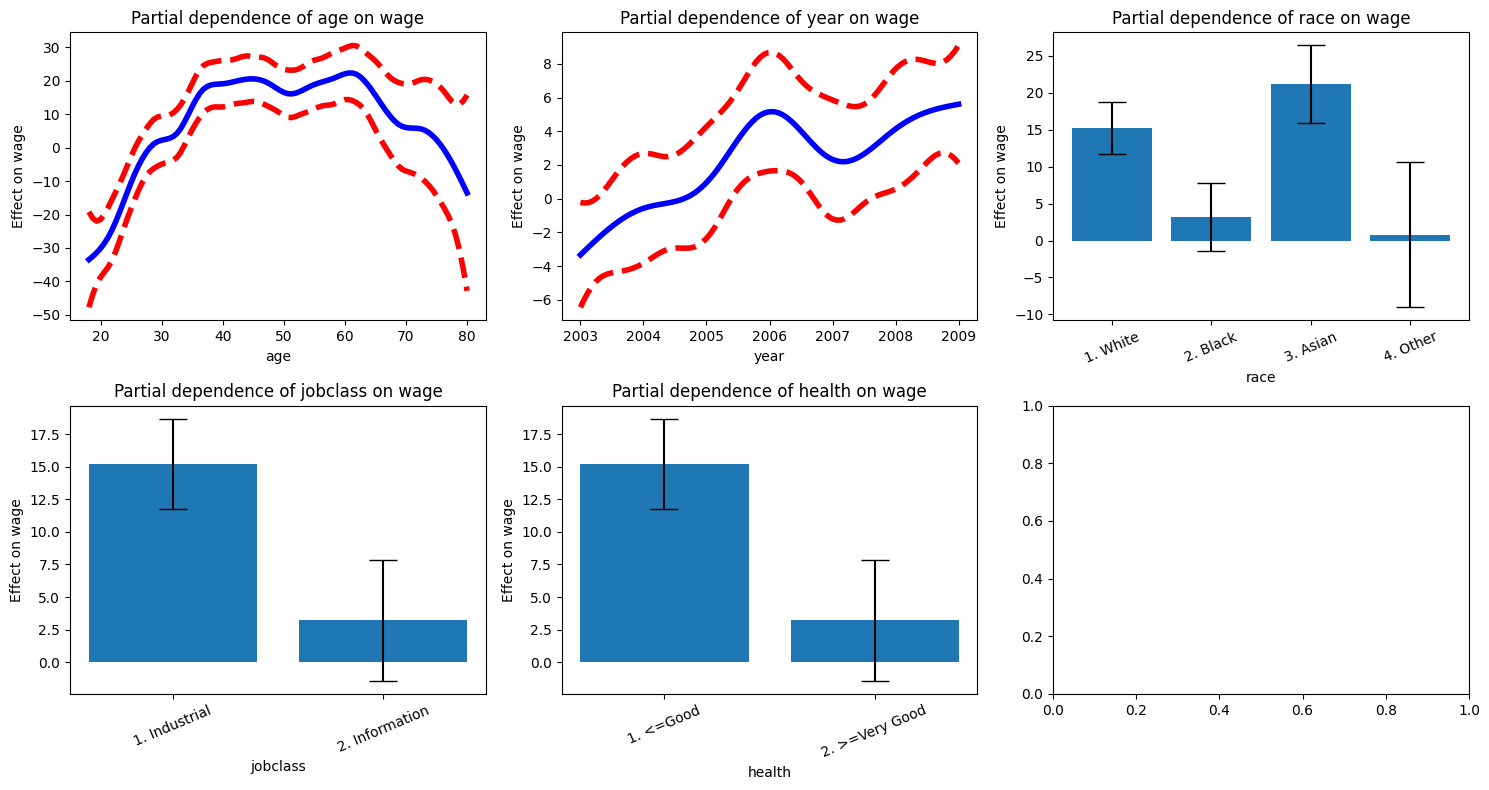

In [ ]:
cols = ['age', 'year', "race", "jobclass", "health"]
gam_sin_maritl = fit_gam(cols, wage)
plot_gam_terms(gam_sin_maritl, cols, wage, 'wage')

In [ ]:
print(anova_gam(gam_sin_maritl, gam_maritl))

        deviance           df  deviance_diff   df_diff         F    pvalue
0  114167.995576  2973.803599            NaN       NaN       NaN       NaN
1  112863.906356  2969.806900     1304.08922  3.996699  8.585766  0.000095


## 8

Vamos a ahondar en el data set Auto. Existe alguna relacion no lineal entre los regresores ?


In [3]:
auto = load_data("Auto")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [4]:
auto.isna().sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
year,0
origin,0


In [5]:
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


<Axes: >

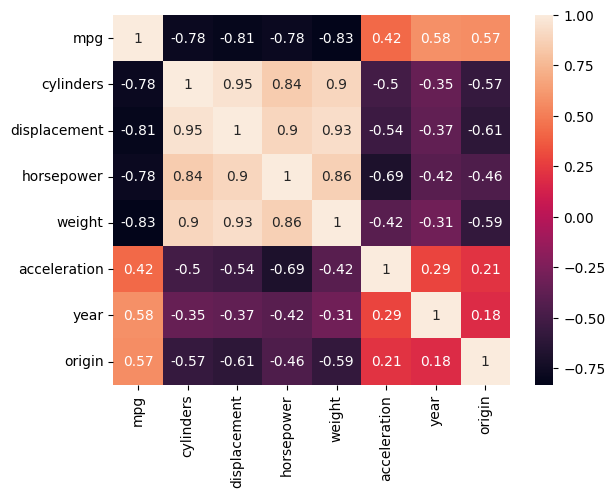

In [6]:
sns.heatmap(auto.corr(), annot=True)

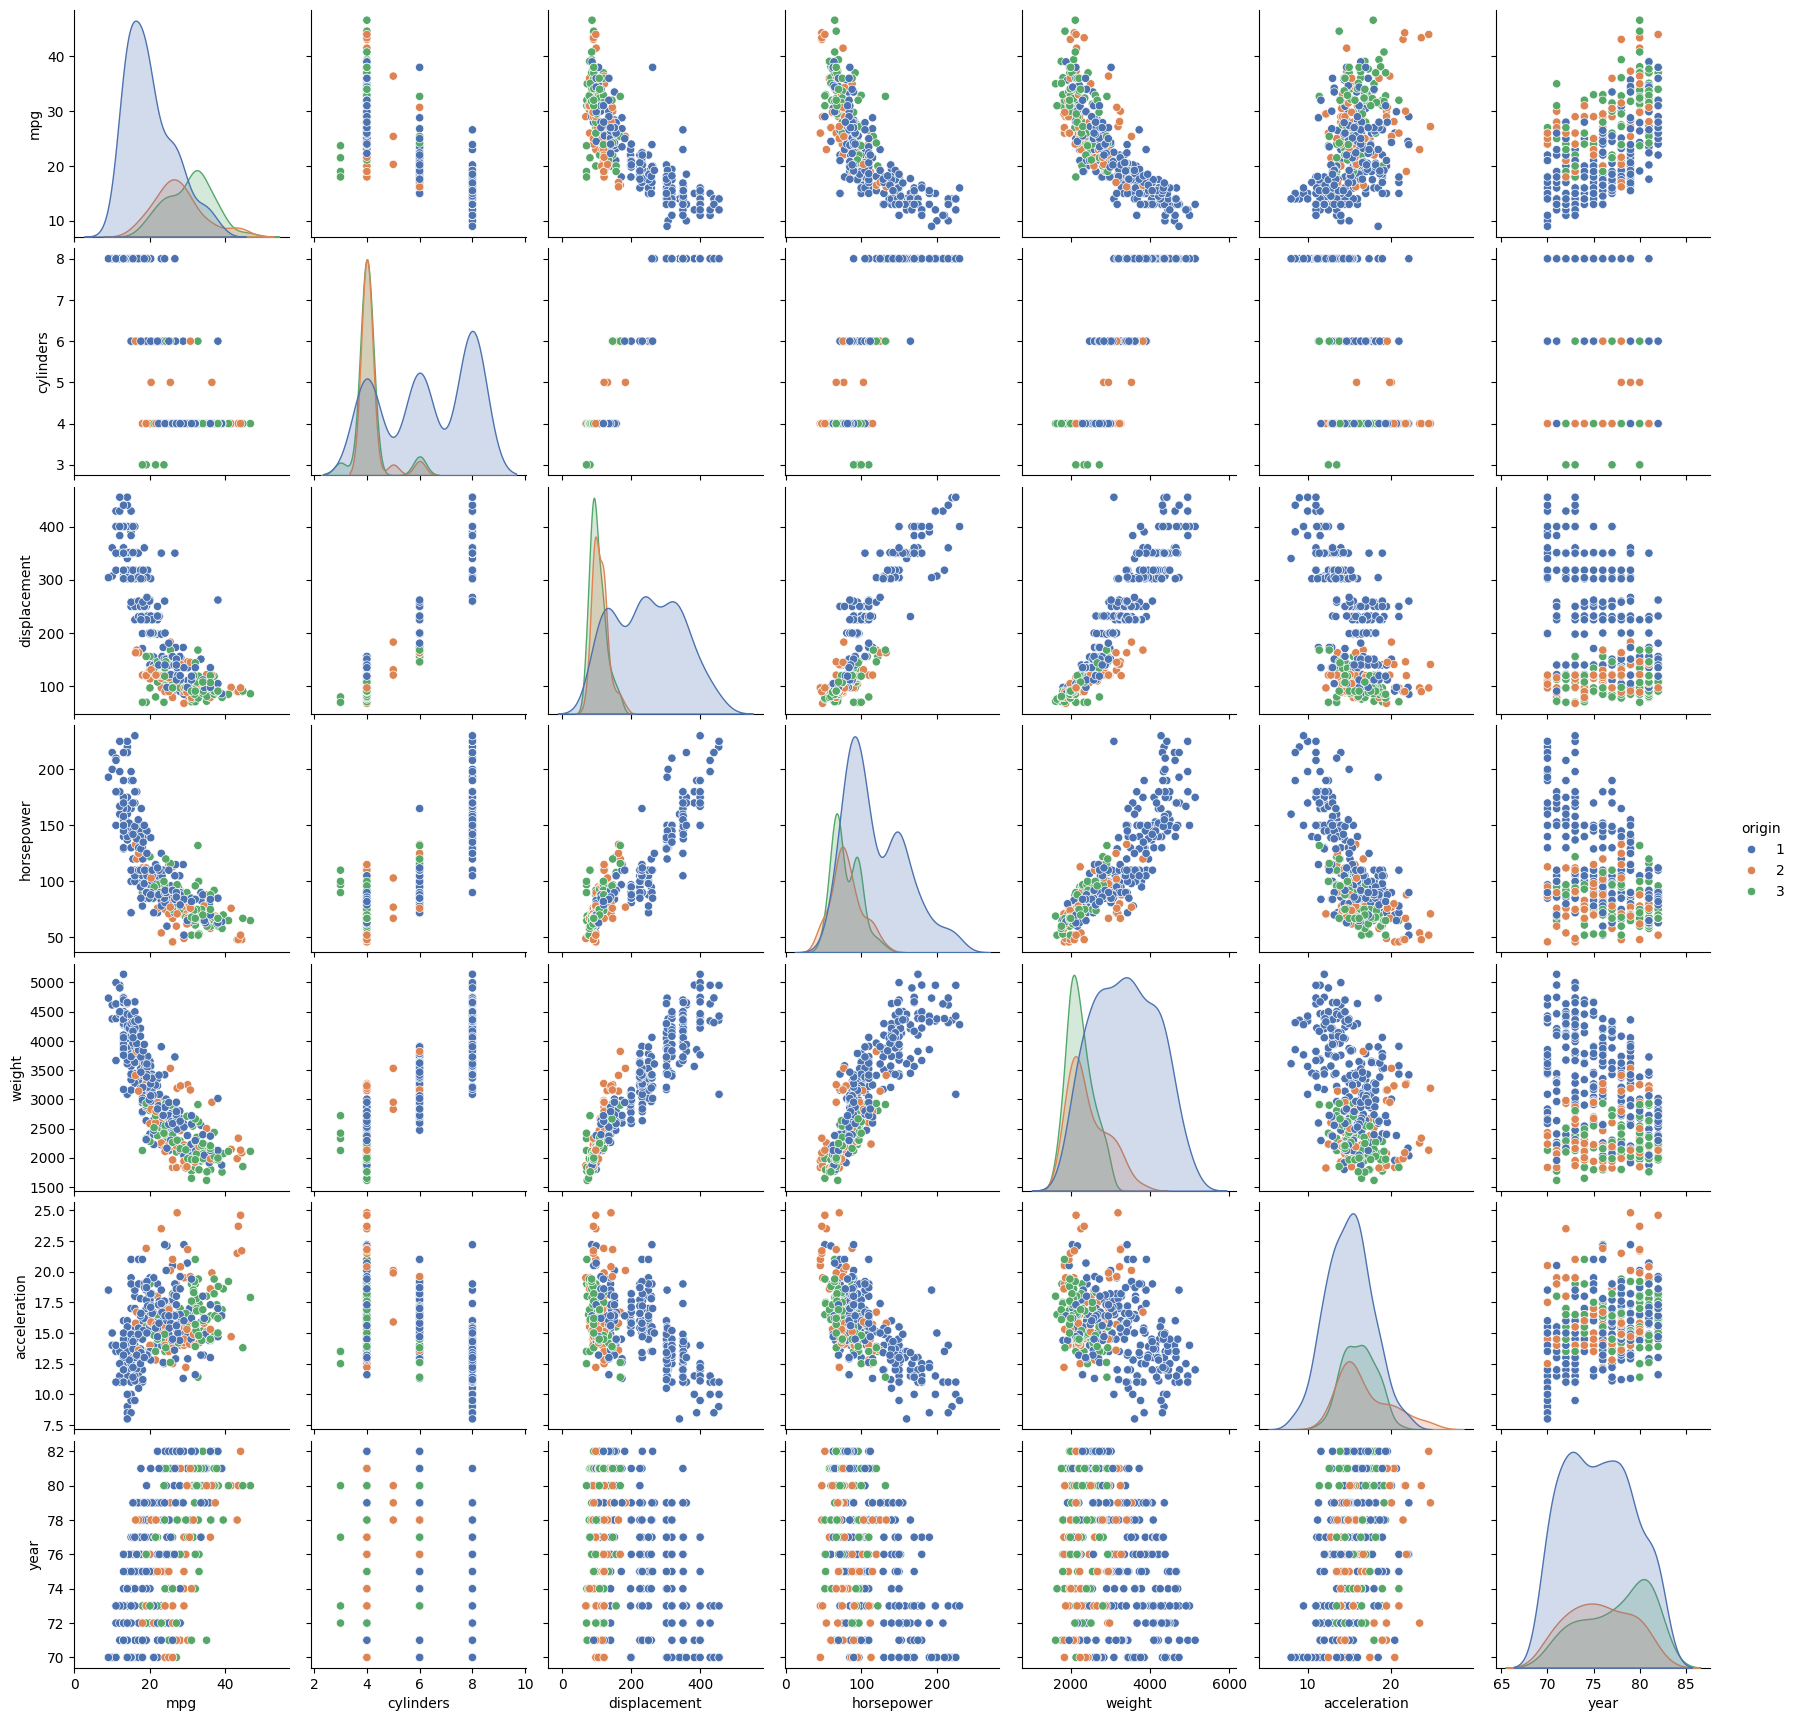

In [7]:
sns.pairplot(auto, hue="origin", palette="deep")

In [7]:
# Veamos una regresion multiple con los features del data set
# Datos
